# 06 - Masking and extracting signals from brain data

Masks are an important concept for analyzing neuroimaging data. Remember, when we made our first steps within the Nipype framework: Here, we already encountered masks when we used FSL's brain extraction tool (```BET```). Defining which voxels belong to the brain and which not is one application of masking. However, there are several other uses cases as we will find out in this session.

#### Questions

- What's a brain mask?
- How can we extract time series data from given brain regions?

#### Objective

- Mask fMRI data
- Extract time series data from pre-defined regions of interest (ROI-analysis)
- Get to know different masking strategies implemented in Nilearn

---

## What's a mask?

Mathematically, a brain mask is a matrix full of 0s and 1s where all the 1s define voxels that are relevant for the given the analysis. Take for example the brain mask we obtained using FSL's ```BET```: Here, all voxels that belong to the brain are represented as a 1 whereas all out-of-brain voxels are coded as 0. We can now use this information to for example restrict a GLM analysis to only brain voxels (because why would care to analyze background voxels) - a computationally efficient way (in fact, Nilearn does this automatically for its ```FirstLevelModel``` class if not specified differently).

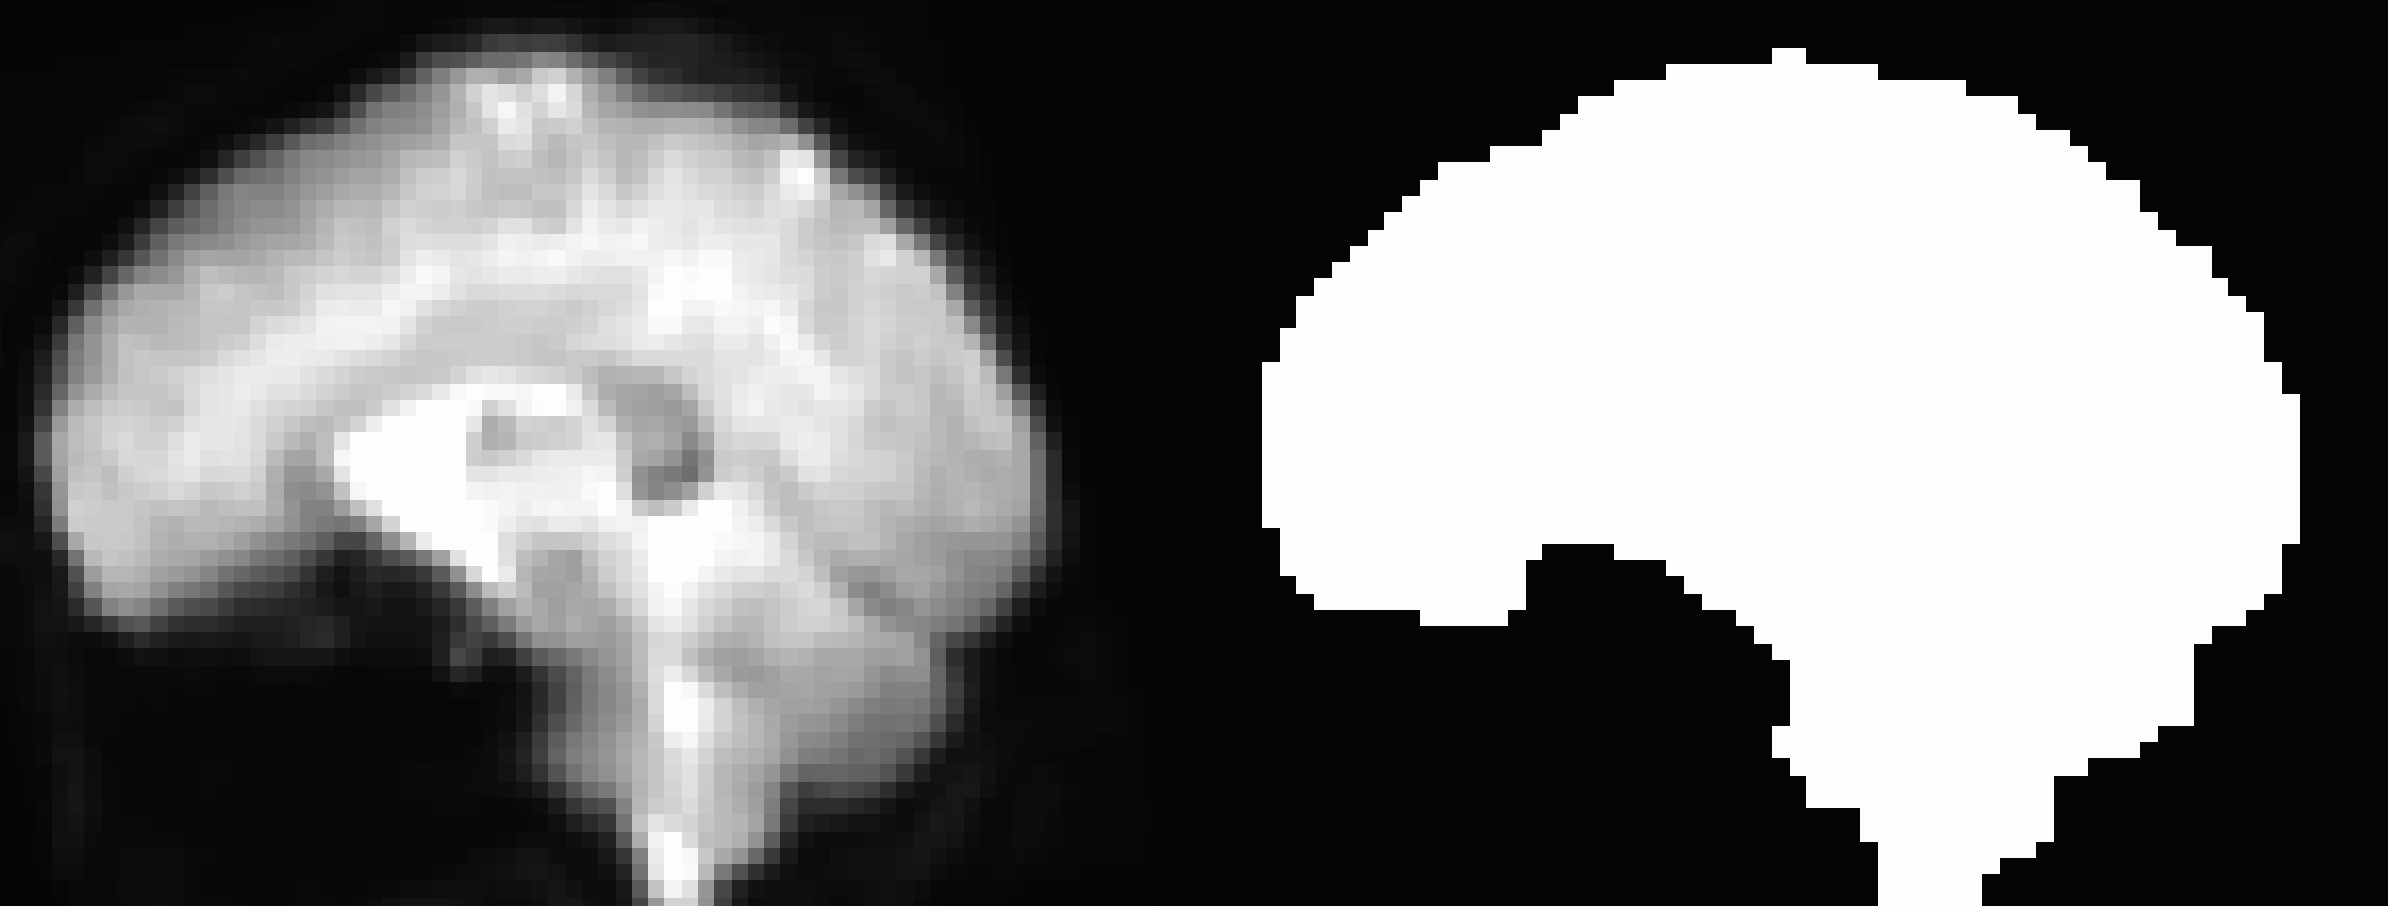
*Example of a brain mask: white voxels represent a 1 and are to be included in the analysis whereas black voxel represent a 0 - Source: [AndysBrainBook](https://andysbrainbook.readthedocs.io/en/latest/AFNI/AFNI_Short_Course/AFNI_Preprocessing/06_AFNI_Masking_Scaling.html)*

## ROI analysis

So far, we have only dealt with **whole-brain** or **explanatory** approaches. That is, we included all brain voxels (see brain mask above) in our analyses. However, if you are working on a topic that has been extensively studied in the past (and you thus have an intiution regarding key regions, it can make sense to limit the analysis to a specific pre-defined region (say for example limiting the analysis of a memory paradigm to hippocampal structures). This approach is referred to as **region of interest (ROI) analysis** (or: **confirmatory analysis**) and can allow for more powerful statistical inference.

As you might have guessed by now, what you need for ROI-analysis is a mask of your ROI (i.e., information which voxels are to be included in the analysis)

### Where to get ROI masks from?

#### Atlas-based masks

One option you have is to use an **atlas**: An atlas is map that divides the brain into anatomically distinct regions (this is also called *parcellation*).

There are different atlasses you can use. In fact, Nilearn currently ships with 18 atlasses - see [here](https://nilearn.github.io/stable/modules/datasets.html#atlases). One commonly used atlas is the [Harvard-Oxford atlas](https://scalablebrainatlas.incf.org/human/HOA06) that comes with FSL. Let's have a look:

In [ ]:
!pip install nilearn==0.9.2

In [ ]:
from pprint import pprint
from nilearn import datasets, plotting, image

atlas = datasets.fetch_atlas_harvard_oxford("cort-prob-2mm")
print(f"This atlas includes {len(atlas.labels) - 1} regions")
print(f"Shape of the atlas: {atlas.maps.shape}")
print(f"The atlas image is located at: {atlas.filename}")


Great! We have loaded the atlas (a single ```.nii.gz``` file) and know that it includes 48 regions (we subtract 1 because the background is included as a region) - stored in the 4th dimension of the nifti file.

The atlas also comes with anatomical labels of these regions:

In [ ]:
pprint(atlas.labels)

Let's plot the whole atlas:

In [ ]:
plotting.plot_prob_atlas(atlas.maps,
                         title="Probabilistic Harvard-Oxford Atlas, 2mm")

We can also access the individual regions using the ```index_img``` function from Nilearn's ```image``` module. Let's have a look at the Angular Gyrus and the Temporal Pole (exluding the background, thus we need to subtract 1 to get the correct index):

In [ ]:
for roi in ["Angular Gyrus", "Temporal Pole"]:
  roi_idx  = atlas.labels.index(roi) - 1
  roi_mask = image.index_img(atlas.maps, index=roi_idx)
  plotting.plot_roi(roi_mask, title=roi, colorbar=True)

As you can see the regions are plotting in different color (other than the whole-brain mask at the beginning of this notebook). This is because we are dealing with a **probabilistic** atlas which accounts for anatomical variablity within a population of different humans (i.e., voxels with high numbers represent that region in almost every participant).

If we want to have a ROI with only 0s and 1s (an **deterministic** ROI) we need to binarize the mask first, providing a threshold for which voxels are included or excluded. We can do this easily with Nilearn's ```binarize_img``` function:

In [ ]:
roi_idx = atlas.labels.index("Angular Gyrus") - 1
roi_mask = image.index_img(atlas.maps, roi_idx)
roi_mask_binarized = image.binarize_img(roi_mask, threshold="10%")

plotting.plot_roi(roi_mask_binarized, title="Angular Gyrus")

Here, we set a threshold of 10%. However, there is no standard threshold, so it's up to you to decide how much of the region you want to keep. If you set no threshold, you will get everything of that region but also bits of other structures as well. As always, this decision depends on the research question at hand.

Now we know how to create masks using atlas. There are other ways to get a mask, though. Let's have a look.

#### Pre-defined masks

Another way to perform a ROI-analysis is to do it based on a pre-defined mask. That is, using a .nii file that contains the info regarding which voxels make up that region. We could for example save that mask we created above and it use it again in another project. Or, your colleague might share a mask file that you could use in your analysis. Another possibility is to obtain a mask from online repositories, such as www.neurovault.org.

Let's try that and download a VMPFC mask from neurovault using the GNU/Linux command ```wget```:

In [ ]:
!wget https://neurovault.org/media/images/3462/VMPFC_mask_neurosynth_liberal.nii.gz

In [ ]:
import nibabel as nib

vmpfc_mask = nib.load("/content/VMPFC_mask_neurosynth_liberal.nii.gz")
print(f"shape of the mask: {vmpfc_mask.shape}")

In [ ]:
plotting.plot_roi(vmpfc_mask, title="VMPFC - probabilistic")
plotting.plot_roi(image.binarize_img(vmpfc_mask, "10%"),
                  title = "VPMC - binarized")

#### Spherical masks

So far, we have dealt with anatomical masks. Another way is to use **spherical ROIs**. Here, we provide x-, y-, z-coordinates (oftentimes obtained from peak activations reported in other studies) and a radius in mm. The result is a sphere around that center coordinates.

In Python, we can create our own spherical mask using the ```nltools``` package:

In [ ]:
!pip install nltools

Let's recreate the mask of the dorsal anterior cingulate cortex used in Rütgen et al. (2015):

In [ ]:
from nltools.mask import create_sphere

# mni coordinates
dacc_coords = (3, 6, 36)
dacc_sphere = create_sphere(dacc_coords, radius=10)

plotting.plot_roi(
    dacc_sphere,
    title="dorsal anterior cingulate cortex - 10mm radius")

We can save the created sphere using Nibabel's ```save``` function (this holds for the other mask creation approaches as well):

In [12]:
nib.save(dacc_sphere, "dacc_sphere.nii")

### Implementation in Nilearn

Maskers are a central concept in Nilearn. Basically, it allows one to transform 3D/4D MRI/fMRI data to a 2D matrix (where samples x features). Most of the time, samples are timepoints in an fMRI experiment whereas features relate to different regions of interest.

That is, transforming the data so that we get a matrix with signal time-series for our regions of interest. This is in important concept for the analysis of functional connectivity (e.g. during resting state)

You can find a comprehensive overview on Nilearn masker objects in the official [user guide](https://nilearn.github.io/dev/manipulating_images/masker_objects.html)

#### Extract ROI data from contrast maps

For now, we will concentrate on how to extract contrast values for given ROIs. That is, for a certain number of participants we want to obtain the mean contrast value in a specific ROI.

To return to the example from last weeks, let's consider the Right vs. left button press task and get an estimate of the mean activation in the left motor cortex (because we know from theory that we should find activation here) and compare it to the right motor cortex. First, let's download the data:

In [ ]:
n_subjects = 20

con_right_left = datasets.fetch_localizer_contrasts(
    ["right vs left button press"], n_subjects)


Next, we need masks of the left and right precentral gyri, respectively. Since we are now interested in lateralized regions, we need to get a lateralized version of the atlas:

In [14]:
atlas_lateralized = datasets.fetch_atlas_harvard_oxford("cortl-prob-2mm")       #cortl = cortical lateralized

We'll also create a short helper function to select specific regions:

In [15]:
def get_roi(atlas, roi_label, thresh):
  '''Extracts ROI mask from atlas based on verbal label'''

  roi_idx  = atlas.labels.index(roi_label) - 1
  roi_mask = image.index_img(atlas.maps, roi_idx)
  roi_mask_bin = image.binarize_img(roi_mask, threshold=thresh)

  return roi_mask_bin

In [ ]:
rois = ["Left Precentral Gyrus", 'Right Precentral Gyrus']

for roi in rois:
  roi_mask = get_roi(atlas_lateralized, roi, "10%")
  plotting.plot_roi(roi_mask, title=roi)

##### NiftiLabelsMasker
Great, the function works as expected. Now we can go ahead and actually extract some estimates. For this we will use Nilearn's [```NiftiLabelsMasker```](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiLabelsMasker.html). We will start by doing it for one region and one participant. First, we generate a mask and then we instantiate the masker object (this works the same way as setting up the first and second level models in Nilearn):

In [17]:
from nilearn.maskers import NiftiLabelsMasker

# get contrast map of first subject
test_subj = con_right_left.cmaps[0]

# get roi mask
left_precentral_gyrus = get_roi(
    atlas_lateralized, "Left Precentral Gyrus", "10%")

# instantiate masker object
masker = NiftiLabelsMasker(left_precentral_gyrus)

Once the masker object has been instantiated, we can extraced the contrast estimate from the contrast map using the ```fit_transform``` method and providing the data of our subject:

In [ ]:
left_precentral_mean = masker.fit_transform(test_subj)
print(f"Mean contrast estimate in the left precentral gyrus: {left_precentral_mean}")

This value we got is the contrast estimate averaged across all voxels included in the mask.


#### NiftiSpheresMasker

Now, one could argue that the mask we provided was a broad and includes regions other than the M1. One possibility to be more specific would be to use a spherical mask. For this we could either create our own sphere using ```nltools``` (as done above) or use the Nilearn function ```NiftiSpheresMasker```. The MNI coordinates for the left and right M1 are adapted from Zhang et al. (2016).

In [ ]:
m1_coords = {"left_M1":  (-37, -24, 60),
             "right_M1": (37, -24, 60)}

# quickly plot the masks before moving on
for label, coords in m1_coords.items():
  mask = create_sphere(coords, radius=6)
  plotting.plot_roi(mask, title=label)

Looks good! Now let's extract some contrast estimates. This time, however, we will not only use [```NiftiSpheresMasker```](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiSpheresMasker.html) but also applying to all subjects and both regions. To make our lifes easier (and our approach more reproducible), we will create a function for this

In [20]:
from nilearn.maskers import NiftiSpheresMasker
import numpy as np

def extract_roi_sphere(cmaps, coords, radius):
  '''extract mean roi activation from contrast map

     Input:
     - List of contract maps
     - MNI coordinates
     - Sphere radius in mm

  '''

  # instantiate numpy array to store results
  out = np.zeros(len(cmaps))

  # setup masker
  masker = NiftiSpheresMasker([coords], radius=radius)

  # loop over subjects
  for i, cmap in enumerate(cmaps):
    print(f"processing subject {i+1}")
    out[i] = masker.fit_transform(cmap)
    print("done\n")

  return out


In [21]:
# turn of nilearn warnings regarding NaN values
import warnings
warnings.simplefilter("ignore", UserWarning)

In [ ]:
left_m1_means = extract_roi_sphere(
    con_right_left.cmaps, m1_coords["left_M1"], radius=6)

right_m1_means = extract_roi_sphere(
    con_right_left.cmaps, m1_coords["right_M1"], radius=6)

In [ ]:
pprint(left_m1_means)
pprint(right_m1_means)


## References & Resources

Rütgen, M., Seidel, E. M., Silani, G., Riečanský, I., Hummer, A., Windischberger, C., ... & Lamm, C. (2015). Placebo analgesia and its opioidergic regulation suggest that empathy for pain is grounded in self pain. Proceedings of the National Academy of Sciences, 112(41), E5638-E5646.

Zhang, Y., Liu, H., Wang, L., Yang, J., Yan, R., Zhang, J., ... & Qiu, M. (2016). Relationship between functional connectivity and motor function assessment in stroke patients with hemiplegia: a resting-state functional MRI study. Neuroradiology, 58(5), 503-511.

Analogous example for ROI analysis in SPM: http://andysbrainblog.blogspot.com/2014/07/quick-and-efficient-roi-analysis-using.html